In [183]:
import numpy as np
from data.generateARMA  import generate as gA
from data.generateHarmonics  import generate as gH
from data.generateTrend  import generate as gT
import matplotlib.pyplot as plt
from scipy.stats import nbinom
import pandas as pd
def AR_stable(coeff):
    return not (sum(np.abs(np.roots([1] + list(-1 * np.array(coeff[:])))) > 1) > 0)


def arma_data(arLags, maLags, noiseSD, timeSteps, startingArray=None):
    if startingArray == None:
        startingArray = np.zeros(np.max([len(arLags), len(maLags)]))  # start with all 0's
    noiseMean = 0.0
    (observedArray, meanArray, errorArray) = gA.generate(arLags, maLags, startingArray, timeSteps, noiseMean, noiseSD)

    return (observedArray, meanArray)


def generate_ARMA(timeSteps, ar_lags =0, ar = None, ma = None,  noise_sd = 1):
    signal = np.zeros(timeSteps)
    if ar_lags > 0:
        if ar is None:
            ar = np.random.random(ar_lags)
            while not (AR_stable(ar)):
                ar = np.random.random(ar_lags)
        if ma is None:
            ma = []
        ar_sig, _ = arma_data(ar, ma, noise_sd, timeSteps, startingArray=None, )
        signal += ar_sig

    return signal


In [216]:
def plot_spectrum(y):
    T = len(y)
    L = int(np.sqrt(T))
    N = T//L
    A = y[:L*N].reshape([L,N])
    A = A -np.mean(A)
    u,s,v = np.linalg.svd(A)
    S = np.cumsum(s**2)
    S = S/S[-1]
    plt.figure()
    plt.plot(S[:20], '-o')
    plt.xlabel('k')
    plt.ylabel('Energy of top k Singular Values')
    plt.title('Time series Spectrum')
    plt.ylim([0,1])
    plt.show()
    return S

NO_ANOMALIES_PARAMETER = 3.05
FRACTION_OF_POINT_ANOMALIES = 0.2121
NEG_BIN_PARA =  (0.13366790655765667,0.0006840451345743173)

def add_anomalies(y):
    n_points = np.random.poisson(NO_ANOMALIES_PARAMETER, 1)[0]
    an_points = np.random.randint(0,T-1,n_points)
    an_points = sorted(an_points)
    an_points.append(T)
    mean, std = np.mean(y), np.std(y)
    an_data = np.array(y)
    start = []
    end = []
    p = FRACTION_OF_POINT_ANOMALIES
    for i,point in enumerate(an_points[:-1]):
        start.append(point)
        anomaly_length =  r = nbinom.rvs(NEG_BIN_PARA[0], NEG_BIN_PARA[1], size=1)[0]+2 if np.random.random()>p else 1
        anomaly_length = min(T, point+anomaly_length)- point
        anomaly_length = min(anomaly_length, 500, an_points[i+1]-point-1,1)
        end.append(point+ anomaly_length)
        an_data[point: point+ anomaly_length] += std/2*np.random.randn(anomaly_length) 
    return an_data, start, end

# Generate time series with low-rank dynamics

Vary the rank between ~3 to ~11


In [217]:
T = 2500
i =0
data = {}
for h in range(1,15,1):
    for j in range(10):
        data[i] = {}
        sineCoeffArray = np.random.randn(h)
        sinePeriodsArray = 10 + (T//30)*np.random.random(h)
        damper = 0.005* np.random.randn()
        har_component = gH(sineCoeffArray, sinePeriodsArray, [], [], T)
        trend_component = gT(power = 1, displacement = 0, timeSteps = T,damper = damper)
        data[i]['signal'] = har_component + trend_component + 0.2*np.random.randn(T)
        data[i]['anomalous_signal'], start, end = add_anomalies(data[i]['signal'])
        df = pd.DataFrame()
        df['timestamp'] = np.arange(1,T+1)
        df['value'] = data[i]['anomalous_signal']
        df.to_csv(f'../synthetic_data/synthetic_lowrank_h{h}_{j}.csv', index = False)
        
        df = pd.DataFrame()
        df['start'] = start
        df['end'] = end
        df.to_csv(f'../synthetic_data/synthetic_lowrank_h{h}_{j}_truth.csv', index = False)
#         plt.figure()
#         plt.plot(data[i]['anomalous_signal'] )
#         for s,e in zip(start,end):
#             plt.axvspan(s, e, alpha=0.5, color='red')
        
#       
        i+=1
        
        

# Generate time-series with ~full-rank dynamics





In [218]:
T = 2500
i =0
data_hr = {}
for h in range(1,15,1):
    for j in range(10):
        data_hr[i] = {}
        sineCoeffArray = 0.05*np.random.randn(h)
        sinePeriodsArray = 10 + (T//10)*np.random.random(h)
        damper = 0.001* np.random.random()
        har_component = gH(sineCoeffArray, sinePeriodsArray, [], [], T)
        trend_component = gT(power = 1, displacement = 0, timeSteps = T,damper = damper)
        arma_component = generate_ARMA(timeSteps= T, ar= 6, ma=np.random.random(5),noise_sd= 0.2)
        data_hr[i]['signal'] =   0.2*np.random.randn(T) + arma_component + har_component
        data_hr[i]['anomalous_signal'], start, end = add_anomalies(data_hr[i]['signal'])
        df = pd.DataFrame()
        df['timestamp'] = np.arange(1,T+1)
        df['value'] = data_hr[i]['anomalous_signal']
        df.to_csv(f'../synthetic_data/synthetic_highrank_h{h}_{j}.csv', index = False)

        df = pd.DataFrame()
        df['start'] = start
        df['end'] = end
        df.to_csv(f'../synthetic_data/synthetic_highrank_h{h}_{j}_truth.csv', index = False)

# Adding Anomalies


4 340
4 1
4 11
4 2


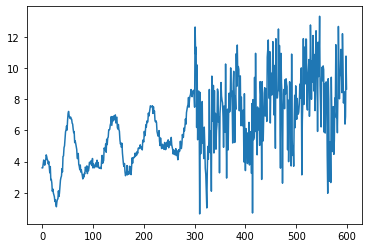

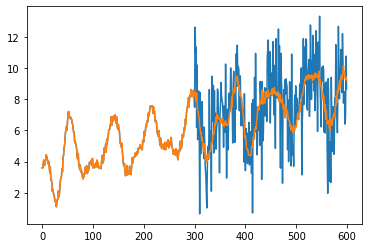

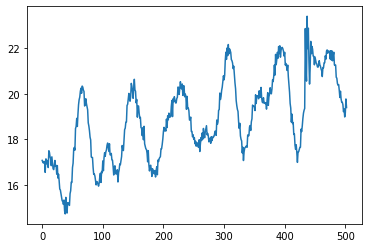

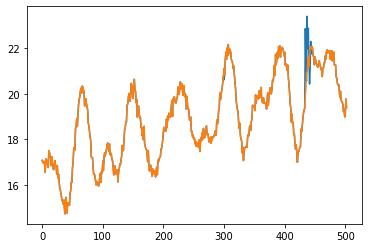

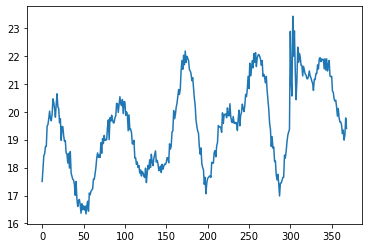

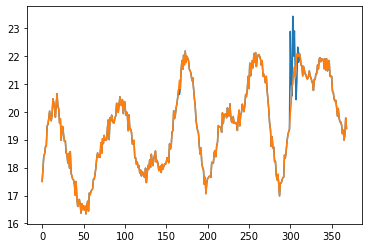

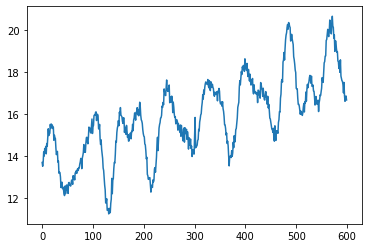

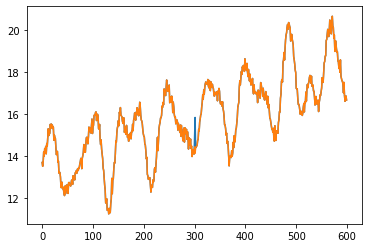

In [177]:
for key in data:
    n_points = np.random.poisson(NO_ANOMALIES_PARAMETER, 1)[0]
    an_points = np.random.randint(0,T-1,n_points)
    mean, std = np.mean(data[key]['signal']), np.std(data[key]['signal'])
    an_data = np.array(data[key]['signal'])
#     an_data[an_points] += std*np.random.randn(n_points) + mean
    for point in an_points:
        p = FRACTION_OF_POINT_ANOMALIES
        anomaly_length =  r = nbinom.rvs(NEG_BIN_PARA[0], NEG_BIN_PARA[1], size=1)[0]+2 if np.random.random()>p else 1
        an_data[point: point+ anomaly_length] += std/3*np.random.randn(anomaly_length) 
        print(n_points,anomaly_length)
    
#     for point in an_points:
#         plt.figure()
#         plt.plot(an_data[point-300:point+300])
#         plt.figure()
#         plt.plot(an_data[point-300:point+300])
#         plt.plot(data[key]['signal'][point-300:point+300] )
#     break
    


1

In [155]:
np.random.random()>p 

True

3

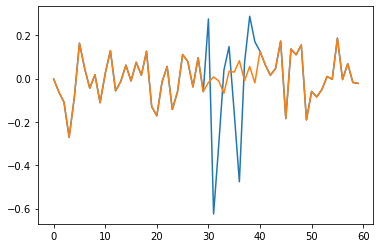

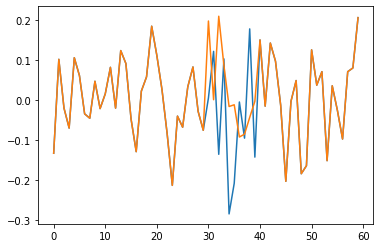

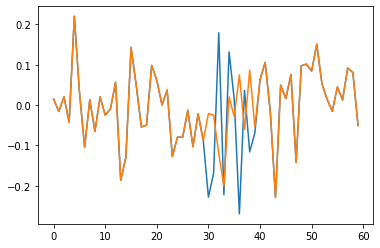

In [127]:
for key in data:
    n_points = np.random.poisson(NO_ANOMALIES_PARAMETER, 1)[0]
    an_points = np.random.randint(0,T-1,n_points)
    mean, std = np.mean(data_hr[key]['signal']), np.std(data_hr[key]['signal'])
    an_data = np.array(data_hr[key]['signal'])
#     an_data[an_points] += std*np.random.randn(n_points) + mean
    
    for point in an_points:
        an_data[point: point+ 10] += 2*std*np.random.randn(10) 
    
    
    for point in an_points:
        plt.figure()
        plt.plot(an_data[point-30:point+30])
        plt.plot(data_hr[key]['signal'][point-30:point+30] )
    break
    
n_points

array([5])